# Lab 12 - Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data ZIP file from [here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and place it under the current directory. 

After that, let’s import some necessities.

In [1]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/NN and NLP/lab 12")

Mounted at /content/drive


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [3]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [4]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [5]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [6]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [7]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len

14500

We are going to create a dataset of pairs without the trimmed words.

In [8]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [ ]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

In [10]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [11]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        self.embeddings = embeddings
        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more

        self.Bidirectional1 = Bidirectional(GRU(self.enc_units, return_sequences=True))
        self.Bidirectional2 = Bidirectional(GRU(self.enc_units, return_sequences=True, return_state = True))
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [13]:
# Creating our encoder by calling the above created Encoder Class
encoder = Encoder(vocab_len, 50, GRU_units)

# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers

        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences = True)
        self.decoder_gru_l2 = GRU(self.units, return_sequences= False, return_state = True)
        self.dropout = Dropout(0.2)
        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [16]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [99]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(11,11))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Adding attention weights to our plot
    for i in range(len(attention)):
        for j in range(len(attention[i])):
            text = ax.text(j, i, attention[i, j], ha="center", va="center", color="w")
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    print(f'Attention scores are:    {attention_plot}' )
    plot_attention(np.round(attention_plot,4), sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [18]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [19]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [20]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 78


We are creating a test_bot to monitor our training in every time step.

Due to high number of epochs, the runtime of colab pro disconnected, hence I have trained my model from the last checkpoint that was saved. Checkpoint number 78. The stored checkpoints have all the information stored, the encoder and decoder parameters, the optimizer parameters, the loss and the iteration all saved. 

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-78")

In [22]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 78 Batch 598 Loss: 1.4409
Epoch 78 Batch 1196 Loss: 1.6235
Epoch 78 Batch 1794 Loss: 1.6333
Epoch 78 Batch 2392 Loss: 1.6973
Epoch 78 Batch 2990 Loss: 1.3834
Epoch 78 Batch 3588 Loss: 1.3538

*** Epoch 78 Loss 1.5054 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a long time 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  78
Time  230.571 sec

Epoch 79 Batch 598 Loss: 1.3943
Epoch 79 Batch 1196 Loss: 1.7983
Epoch 79 Batch 1794 Loss: 1.9012
Epoch 79 Batch 2392 Loss: 1.9540
Epoch 79 Batch 2990 Loss: 1.4921
Epoch 79 Batch 3588 Loss: 1.7660

*** Epoch 79 Loss 1.5045 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your

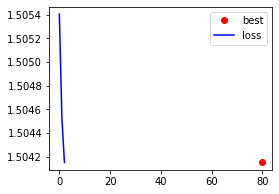

Best epoch so far:  80
Time  225.564 sec

Epoch 81 Batch 598 Loss: 1.2575
Epoch 81 Batch 1196 Loss: 2.0267
Epoch 81 Batch 1794 Loss: 1.8004
Epoch 81 Batch 2392 Loss: 1.8578
Epoch 81 Batch 2990 Loss: 1.5712
Epoch 81 Batch 3588 Loss: 1.7266

*** Epoch 81 Loss 1.5039 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  81
Time  223.884 sec

Epoch 82 Batch 598 Loss: 1.3052
Epoch 82 Batch 1196 Loss: 1.7830
Epoch 82 Batch 1794 Loss: 1.7524
Epoch 82 Batch 2392 Loss: 1.8388
Epoch 82 Batch 2990 Loss: 1.5051
Epoch 82 Batch 3588 Loss: 1.6777

*** Epoch 82 Loss 1.5038 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do it 


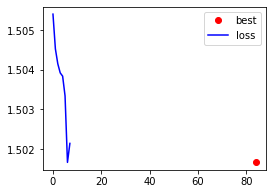

Best epoch so far:  84
Time  231.345 sec

Epoch 86 Batch 598 Loss: 1.3024
Epoch 86 Batch 1196 Loss: 1.9902
Epoch 86 Batch 1794 Loss: 1.9663
Epoch 86 Batch 2392 Loss: 1.8490
Epoch 86 Batch 2990 Loss: 1.5454
Epoch 86 Batch 3588 Loss: 1.7570

*** Epoch 86 Loss 1.5008 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  86
Time  230.181 sec

Epoch 87 Batch 598 Loss: 1.3543
Epoch 87 Batch 1196 Loss: 1.8638
Epoch 87 Batch 1794 Loss: 1.8567
Epoch 87 Batch 2392 Loss: 1.7570
Epoch 87 Batch 2990 Loss: 1.5647
Epoch 87 Batch 3588 Loss: 1.7638

*** Epoch 87 Loss 1.5003 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Gree

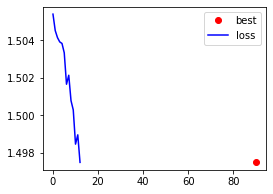

Best epoch so far:  90
Time  226.254 sec

Epoch 91 Batch 598 Loss: 1.3546
Epoch 91 Batch 1196 Loss: 1.9156
Epoch 91 Batch 1794 Loss: 1.9399
Epoch 91 Batch 2392 Loss: 1.8115
Epoch 91 Batch 2990 Loss: 1.5011
Epoch 91 Batch 3588 Loss: 1.7875

*** Epoch 91 Loss 1.4975 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a good time 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am fine 
####################
Best epoch so far:  90
Time  228.885 sec

Epoch 92 Batch 598 Loss: 1.2249
Epoch 92 Batch 1196 Loss: 1.9923
Epoch 92 Batch 1794 Loss: 1.8205
Epoch 92 Batch 2392 Loss: 1.8511
Epoch 92 Batch 2990 Loss: 1.5297
Epoch 92 Batch 3588 Loss: 1.7932

*** Epoch 92 Loss 1.4970 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: 

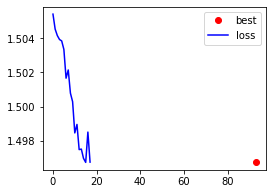

Best epoch so far:  93
Time  229.421 sec

Epoch 96 Batch 598 Loss: 1.3636
Epoch 96 Batch 1196 Loss: 1.9685
Epoch 96 Batch 1794 Loss: 1.9312
Epoch 96 Batch 2392 Loss: 1.9359
Epoch 96 Batch 2990 Loss: 1.5218
Epoch 96 Batch 3588 Loss: 1.9116

*** Epoch 96 Loss 1.4957 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  96
Time  225.214 sec

Epoch 97 Batch 598 Loss: 1.2644
Epoch 97 Batch 1196 Loss: 2.0240
Epoch 97 Batch 1794 Loss: 1.7928
Epoch 97 Batch 2392 Loss: 1.8425
Epoch 97 Batch 2990 Loss: 1.5603
Epoch 97 Batch 3588 Loss: 1.7358

*** Epoch 97 Loss 1.4955 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do i

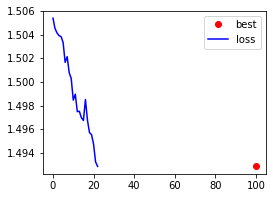

Best epoch so far:  100
Time  234.001 sec

Epoch 101 Batch 598 Loss: 1.3758
Epoch 101 Batch 1196 Loss: 1.9247
Epoch 101 Batch 1794 Loss: 1.9188
Epoch 101 Batch 2392 Loss: 1.9021
Epoch 101 Batch 2990 Loss: 1.5587
Epoch 101 Batch 3588 Loss: 1.8391

*** Epoch 101 Loss 1.4934 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am thirsty 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  100
Time  231.005 sec

Epoch 102 Batch 598 Loss: 1.2938
Epoch 102 Batch 1196 Loss: 1.9723
Epoch 102 Batch 1794 Loss: 1.9607
Epoch 102 Batch 2392 Loss: 1.8399
Epoch 102 Batch 2990 Loss: 1.5583
Epoch 102 Batch 3588 Loss: 1.7605

*** Epoch 102 Loss 1.4944 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%

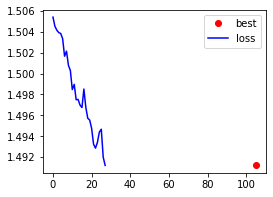

Best epoch so far:  105
Time  225.188 sec

Epoch 106 Batch 598 Loss: 1.3721
Epoch 106 Batch 1196 Loss: 1.8394
Epoch 106 Batch 1794 Loss: 1.8767
Epoch 106 Batch 2392 Loss: 1.9349
Epoch 106 Batch 2990 Loss: 1.5417
Epoch 106 Batch 3588 Loss: 1.8436

*** Epoch 106 Loss 1.4911 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  106
Time  225.224 sec

Epoch 107 Batch 598 Loss: 1.3650
Epoch 107 Batch 1196 Loss: 1.9440
Epoch 107 Batch 1794 Loss: 1.9082
Epoch 107 Batch 2392 Loss: 1.8054
Epoch 107 Batch 2990 Loss: 1.5196
Epoch 107 Batch 3588 Loss: 1.7918

*** Epoch 107 Loss 1.4912 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: Wha

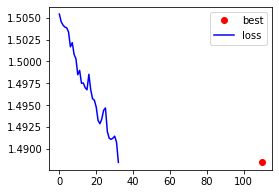

Best epoch so far:  110
Time  224.660 sec

Epoch 111 Batch 598 Loss: 1.3791
Epoch 111 Batch 1196 Loss: 1.7494
Epoch 111 Batch 1794 Loss: 1.8961
Epoch 111 Batch 2392 Loss: 1.9281
Epoch 111 Batch 2990 Loss: 1.4773
Epoch 111 Batch 3588 Loss: 1.7672

*** Epoch 111 Loss 1.4884 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not sure 
####################
check point saved!
Best epoch so far:  111
Time  224.138 sec

Epoch 112 Batch 598 Loss: 1.3535
Epoch 112 Batch 1196 Loss: 1.9729
Epoch 112 Batch 1794 Loss: 1.9245
Epoch 112 Batch 2392 Loss: 1.9559
Epoch 112 Batch 2990 Loss: 1.5228
Epoch 112 Batch 3588 Loss: 1.9195

*** Epoch 112 Loss 1.4882 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?

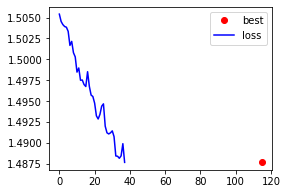

Best epoch so far:  115
Time  225.136 sec

Epoch 116 Batch 598 Loss: 1.4208
Epoch 116 Batch 1196 Loss: 1.7833
Epoch 116 Batch 1794 Loss: 1.8662
Epoch 116 Batch 2392 Loss: 1.9271
Epoch 116 Batch 2990 Loss: 1.3844
Epoch 116 Batch 3588 Loss: 1.7573

*** Epoch 116 Loss 1.4889 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  115
Time  226.130 sec

Epoch 117 Batch 598 Loss: 1.3781
Epoch 117 Batch 1196 Loss: 1.9129
Epoch 117 Batch 1794 Loss: 1.9201
Epoch 117 Batch 2392 Loss: 1.9164
Epoch 117 Batch 2990 Loss: 1.5364
Epoch 117 Batch 3588 Loss: 1.8271

*** Epoch 117 Loss 1.4875 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sleepy 
%
Greedy| Q: What are you doing ?  A: i am going t

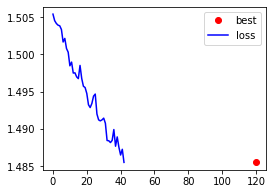

Best epoch so far:  120
Time  225.487 sec

Epoch 121 Batch 598 Loss: 1.4496
Epoch 121 Batch 1196 Loss: 1.8073
Epoch 121 Batch 1794 Loss: 1.7695
Epoch 121 Batch 2392 Loss: 1.9293
Epoch 121 Batch 2990 Loss: 1.3598
Epoch 121 Batch 3588 Loss: 1.6873

*** Epoch 121 Loss 1.4869 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  120
Time  226.045 sec

Epoch 122 Batch 598 Loss: 1.3794
Epoch 122 Batch 1196 Loss: 1.8391
Epoch 122 Batch 1794 Loss: 1.8805
Epoch 122 Batch 2392 Loss: 1.9446
Epoch 122 Batch 2990 Loss: 1.5613
Epoch 122 Batch 3588 Loss: 1.8414

*** Epoch 122 Loss 1.4862 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not stirred 
%
Greedy| Q: What are you doing ?  A: i am going 

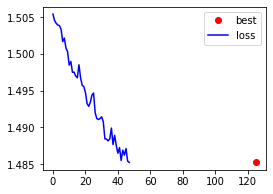

Best epoch so far:  125
Time  229.436 sec

Epoch 126 Batch 598 Loss: 1.4185
Epoch 126 Batch 1196 Loss: 1.5755
Epoch 126 Batch 1794 Loss: 1.6282
Epoch 126 Batch 2392 Loss: 1.6776
Epoch 126 Batch 2990 Loss: 1.3700
Epoch 126 Batch 3588 Loss: 1.3215

*** Epoch 126 Loss 1.4840 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  126
Time  228.892 sec

Epoch 127 Batch 598 Loss: 1.3721
Epoch 127 Batch 1196 Loss: 1.7630
Epoch 127 Batch 1794 Loss: 1.8957
Epoch 127 Batch 2392 Loss: 1.9021
Epoch 127 Batch 2990 Loss: 1.4774
Epoch 127 Batch 3588 Loss: 1.7622

*** Epoch 127 Loss 1.4836 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What ar

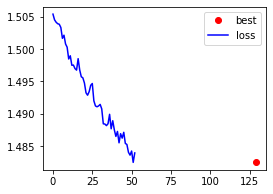

Best epoch so far:  129
Time  231.183 sec

Epoch 131 Batch 598 Loss: 1.3778
Epoch 131 Batch 1196 Loss: 1.6115
Epoch 131 Batch 1794 Loss: 1.6087
Epoch 131 Batch 2392 Loss: 1.7162
Epoch 131 Batch 2990 Loss: 1.3268
Epoch 131 Batch 3588 Loss: 1.4248

*** Epoch 131 Loss 1.4847 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a good roommate 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  129
Time  231.304 sec

Epoch 132 Batch 598 Loss: 1.4314
Epoch 132 Batch 1196 Loss: 1.7724
Epoch 132 Batch 1794 Loss: 1.8728
Epoch 132 Batch 2392 Loss: 1.8935
Epoch 132 Batch 2990 Loss: 1.3762
Epoch 132 Batch 3588 Loss: 1.7432

*** Epoch 132 Loss 1.4825 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i a

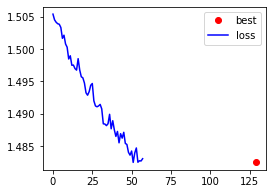

Best epoch so far:  129
Time  230.282 sec

Epoch 136 Batch 598 Loss: 1.4063
Epoch 136 Batch 1196 Loss: 1.6164
Epoch 136 Batch 1794 Loss: 1.5561
Epoch 136 Batch 2392 Loss: 1.7550
Epoch 136 Batch 2990 Loss: 1.3504
Epoch 136 Batch 3588 Loss: 1.5282

*** Epoch 136 Loss 1.4816 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a good time 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving a little 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  136
Time  229.943 sec

Epoch 137 Batch 598 Loss: 1.4400
Epoch 137 Batch 1196 Loss: 1.7877
Epoch 137 Batch 1794 Loss: 1.7556
Epoch 137 Batch 2392 Loss: 1.9130
Epoch 137 Batch 2990 Loss: 1.3537
Epoch 137 Batch 3588 Loss: 1.6854

*** Epoch 137 Loss 1.4819 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Gre

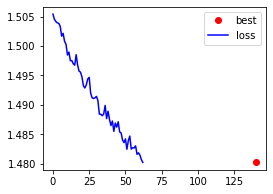

Best epoch so far:  140
Time  229.370 sec

Epoch 141 Batch 598 Loss: 1.3249
Epoch 141 Batch 1196 Loss: 1.6627
Epoch 141 Batch 1794 Loss: 1.5704
Epoch 141 Batch 2392 Loss: 1.8055
Epoch 141 Batch 2990 Loss: 1.4132
Epoch 141 Batch 3588 Loss: 1.5299

*** Epoch 141 Loss 1.4861 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
Best epoch so far:  140
Time  229.122 sec

Epoch 142 Batch 598 Loss: 1.4133
Epoch 142 Batch 1196 Loss: 1.5523
Epoch 142 Batch 1794 Loss: 1.6207
Epoch 142 Batch 2392 Loss: 1.6774
Epoch 142 Batch 2990 Loss: 1.3570
Epoch 142 Batch 3588 Loss: 1.3318

*** Epoch 142 Loss 1.4796 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ? 

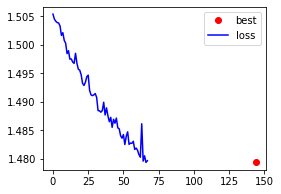

Best epoch so far:  144
Time  229.756 sec

Epoch 146 Batch 598 Loss: 1.3012
Epoch 146 Batch 1196 Loss: 1.7308
Epoch 146 Batch 1794 Loss: 1.7292
Epoch 146 Batch 2392 Loss: 1.8255
Epoch 146 Batch 2990 Loss: 1.4670
Epoch 146 Batch 3588 Loss: 1.6399

*** Epoch 146 Loss 1.4795 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not a good roommate 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  144
Time  229.654 sec

Epoch 147 Batch 598 Loss: 1.3806
Epoch 147 Batch 1196 Loss: 1.6119
Epoch 147 Batch 1794 Loss: 1.6097
Epoch 147 Batch 2392 Loss: 1.7310
Epoch 147 Batch 2990 Loss: 1.3202
Epoch 147 Batch 3588 Loss: 1.4155

*** Epoch 147 Loss 1.4798 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not true 
%
Greedy| Q: What are you doing ?  A: i am g

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

The best model is the model at epoch 149

In [85]:
checkpoint.restore(str(emb_dim)+"-ckpt-149")

In [86]:
test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################


Input: how old are you
Predicted answer: sixteen 
Attention scores are:    [[0.52890342 0.00332699 0.00565497 0.02820913]]


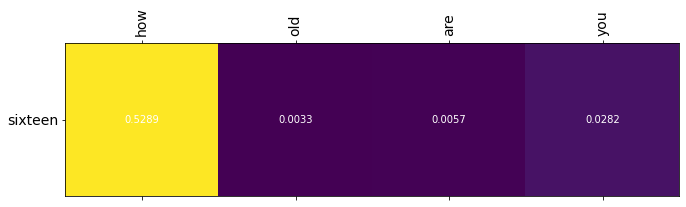

In [107]:
q = "How old are you"
answer(q, training=False)

Input: do you drink
Predicted answer: no 
Attention scores are:    [[0.5706 0.0085 0.1001]]


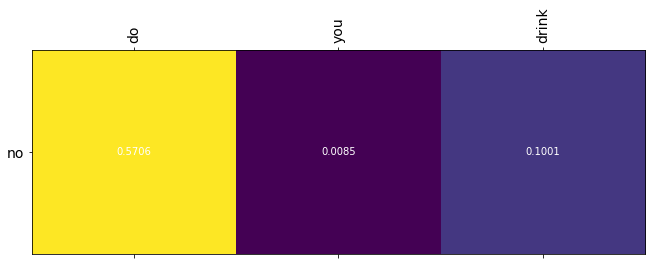

In [90]:
q = "Do you drink"
answer(q, training=False)

**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.

# TASK 3:

Input: how old are you
Predicted answer: i am sorry 
Attention scores are:    [[0.58115864 0.00323345 0.00367905 0.10093919]
 [0.45683575 0.00467216 0.00462146 0.0587715 ]
 [0.22525737 0.00140332 0.00151795 0.02157524]]


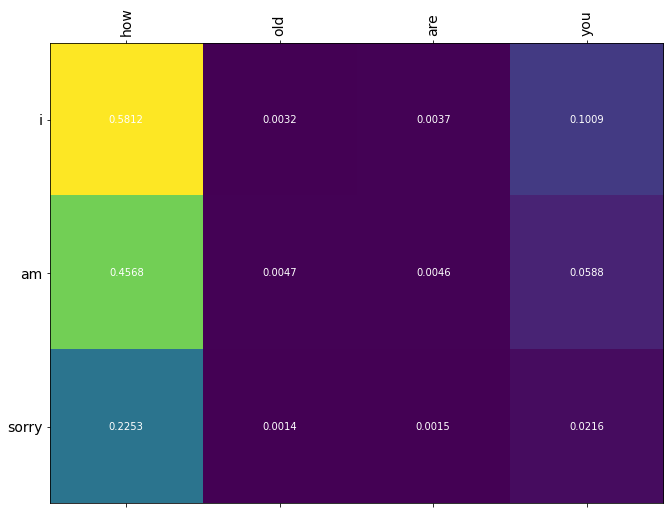

In [126]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")
answer(q, training=False)

### The model trained on just 5 epochs cannot be expected to produce quality results and it did not indeed. It predicted the answer 'i am sorry' for the question 'how old are you' which is a bad answer to the question asked.

Input: how old are you
Predicted answer: i am i am i am i am i am i am i am i am i am 
Attention scores are:    [[0.51031542 0.00228203 0.00178046 0.09641837]
 [0.4517718  0.00688669 0.00595146 0.07801477]
 [0.3718161  0.00382409 0.00229524 0.01955774]
 [0.46315464 0.00538294 0.00402835 0.08344997]
 [0.37402633 0.00377356 0.00229662 0.01920341]
 [0.46445879 0.00537192 0.00399833 0.08297639]
 [0.37436953 0.00376321 0.00229305 0.01918302]
 [0.46465632 0.00537091 0.00399441 0.08290251]
 [0.37441865 0.00376165 0.00229249 0.01918015]
 [0.46468484 0.00537075 0.00399384 0.08289178]
 [0.37442514 0.00376141 0.00229241 0.01917968]
 [0.46468928 0.00537072 0.00399375 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]
 [0.46468928 0.00537072 0.00399374 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]
 [0.46468928 0.00537072 0.00399374 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]]


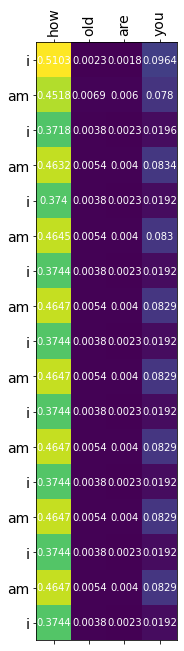

In [109]:
checkpoint.restore(str(emb_dim)+"-ckpt-50")
answer(q, training=False)

### This model which was trained on just 50 epochs prediccted a long repetating sequence which is actually a bad result. It predicted the answer "i am i am i am i am i am i am i am i am i am" for the question "how old are you". 

Input: how old are you
Predicted answer: sixteen 
Attention scores are:    [[0.52890342 0.00332699 0.00565497 0.02820913]]


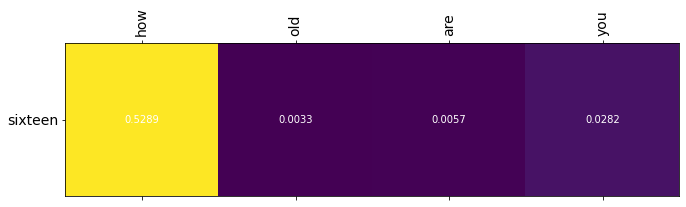

In [129]:
checkpoint.restore(str(emb_dim)+"-ckpt-140")
answer(q, training=False)

### A model which is trained more did a really nice job in answering he question "how old are you". The predicted answer to this question is sixteen which means '16 years' as in age. 

## Creating a funciton with 10 questions and testing the same with our models (5, 50, 140) This funciton will take in the checkpoint number as the input and return the answers to 10 sample questions using the model trained uptil the enteredn checkpoint number.

In [103]:
def test_queries(checkpoint_no):
  question_list = ['how are you','how old are you','where are you','do you drink','do you have fever',
                   'what are you doing','do you like ice cream','do you smoke','what is your name','what is your favourite sport']
  checkpoint.restore(str(emb_dim)+"-ckpt-"+str(checkpoint_no))
  for q in question_list:
    answer(q, training=False)

### Testing our model number 5 (5th checkpoint) for 10 questions and printing its attention scores

Input: how are you
Predicted answer: i am sorry 
Attention scores are:    [[0.57268804 0.00545028 0.10112073]
 [0.46311906 0.0057857  0.05450549]
 [0.21036407 0.00223398 0.02669974]]


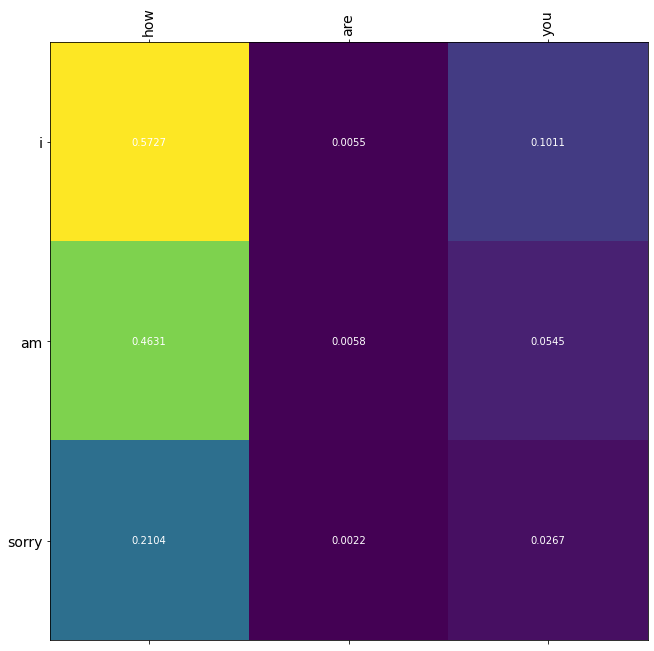

Input: how old are you
Predicted answer: i am sorry 
Attention scores are:    [[0.57232064 0.00404409 0.00425515 0.10387684]
 [0.46562392 0.00486894 0.00477002 0.0549486 ]
 [0.20798293 0.00190436 0.00194705 0.03075165]]


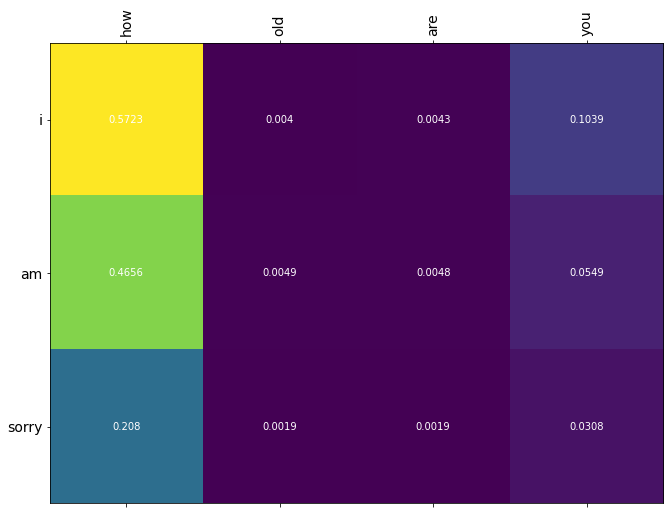

Input: where are you
Predicted answer: i am sorry 
Attention scores are:    [[0.57471138 0.00487964 0.10104363]
 [0.46654657 0.00579132 0.05435349]
 [0.19686902 0.00228849 0.02712956]]


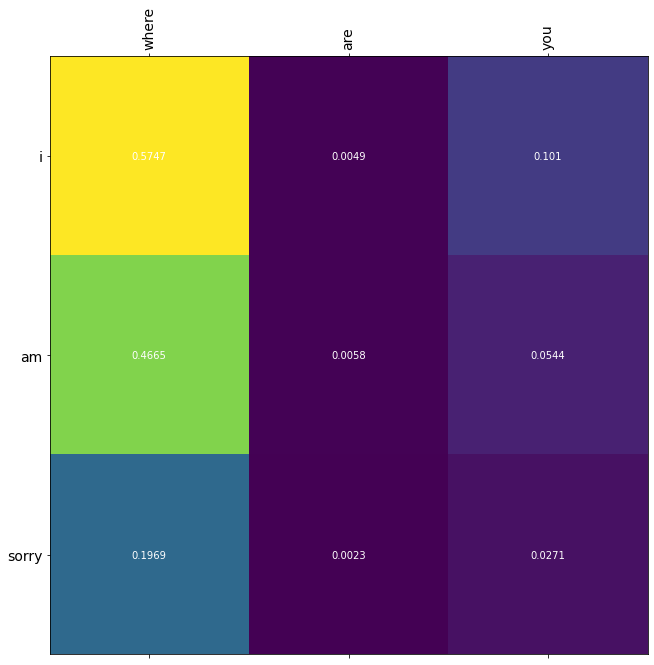

Input: do you drink
Predicted answer: i am sorry 
Attention scores are:    [[0.56186438 0.00672449 0.10437767]
 [0.45261636 0.0060082  0.0557754 ]
 [0.20324746 0.00241528 0.02762517]]


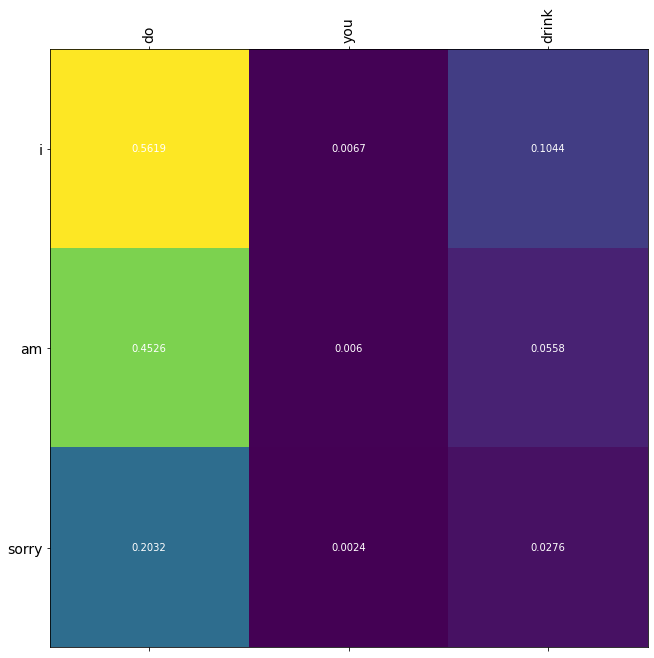

Input: do you have fever
Predicted answer: i am sorry 
Attention scores are:    [[0.55989021 0.00545117 0.00514227 0.10692828]
 [0.4520922  0.00533134 0.00542593 0.05622492]
 [0.20071071 0.0021454  0.00195883 0.03106207]]


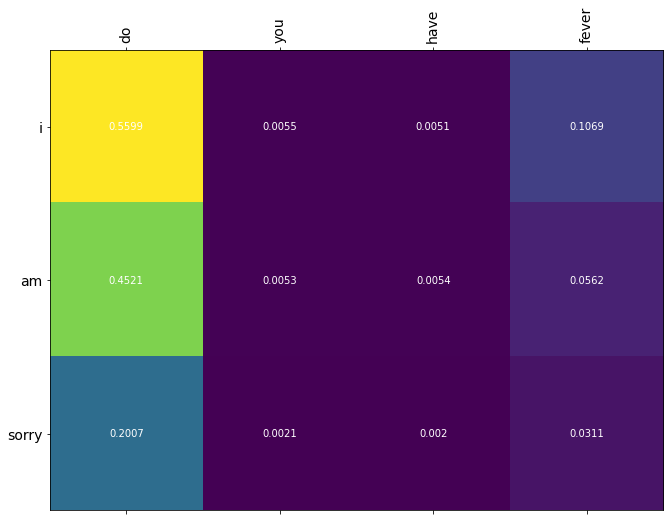

Input: what are you doing
Predicted answer: i am sorry 
Attention scores are:    [[0.57357192 0.00426427 0.00409841 0.102515  ]
 [0.46725285 0.00489079 0.00466647 0.0543421 ]
 [0.21401623 0.00195554 0.00192738 0.02910522]]


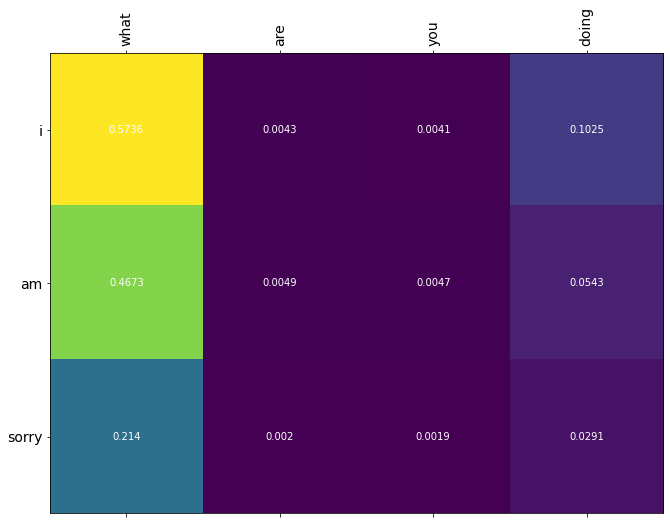

Input: do you like ice cream
Predicted answer: i am sorry 
Attention scores are:    [[0.55816942 0.00476937 0.00400351 0.00408812 0.10917691]
 [0.45109549 0.00488533 0.00449174 0.00459797 0.0566136 ]
 [0.19973476 0.00205734 0.00178739 0.00176017 0.03347083]]


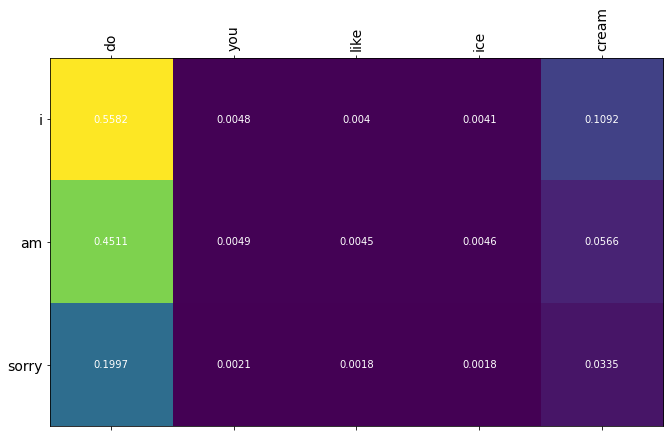

Input: do you smoke
Predicted answer: i am sorry 
Attention scores are:    [[0.56391424 0.00625293 0.10429116]
 [0.45590225 0.00587476 0.05564146]
 [0.20160662 0.00234055 0.02796959]]


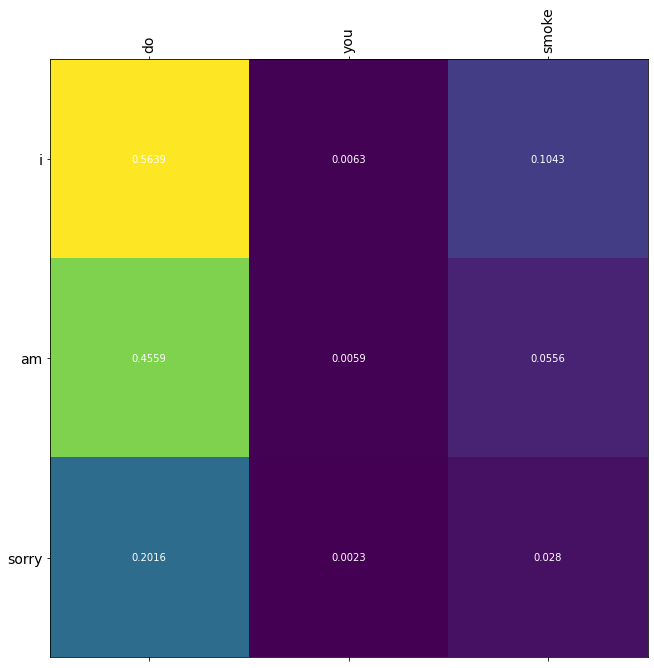

Input: what is your name
Predicted answer: i am sorry 
Attention scores are:    [[0.57600749 0.00409407 0.00390829 0.1031502 ]
 [0.47305891 0.00490445 0.00452893 0.0542202 ]
 [0.20879368 0.00192556 0.00181374 0.03063473]]


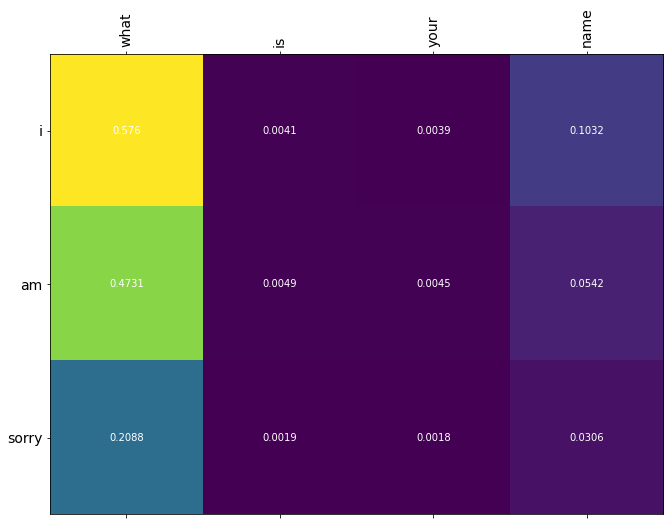

Input: what is your favourite sport
Predicted answer: i am sorry 
Attention scores are:    [[0.57174098 0.00404017 0.00361202 0.00379572 0.10241546]
 [0.46709907 0.00476719 0.00426513 0.00438358 0.05396452]
 [0.20914225 0.00191387 0.00176493 0.00175789 0.02949462]]


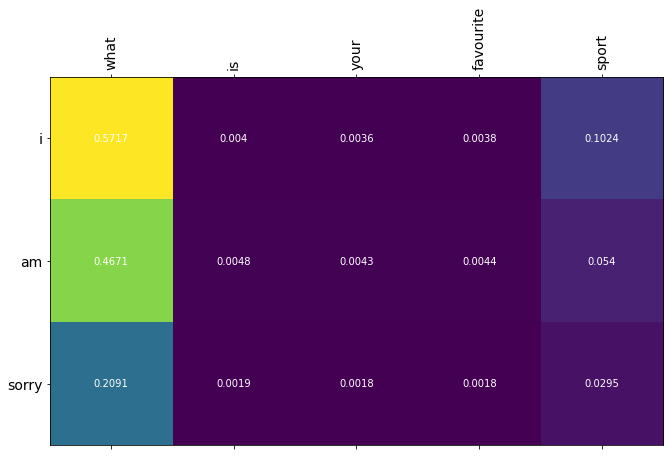

In [114]:
test_queries(4) # 5th epoch

### Testing our model number 50 (50th checkpoint) for 10 questions and printing its attention scores

Input: how are you
Predicted answer: i am not 
Attention scores are:    [[0.53683996 0.00154662 0.11198222]
 [0.42153233 0.0070568  0.04876837]
 [0.28069368 0.00181041 0.0185871 ]]


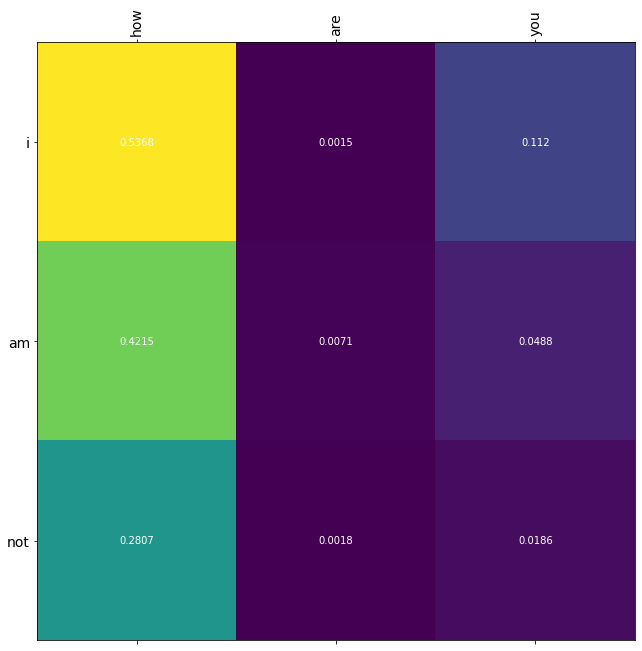

Input: how old are you
Predicted answer: i am not the gestapo 
Attention scores are:    [[5.47407508e-01 2.15142616e-03 1.62470364e-03 9.76890624e-02]
 [3.89068037e-01 7.77330156e-03 7.74988206e-03 9.05510932e-02]
 [2.80811131e-01 2.96099065e-03 2.29623006e-03 2.41602324e-02]
 [2.12046415e-01 2.74786819e-03 2.14384147e-03 1.36536106e-01]
 [1.05789147e-01 2.48864126e-05 5.06626493e-05 1.41899437e-01]]


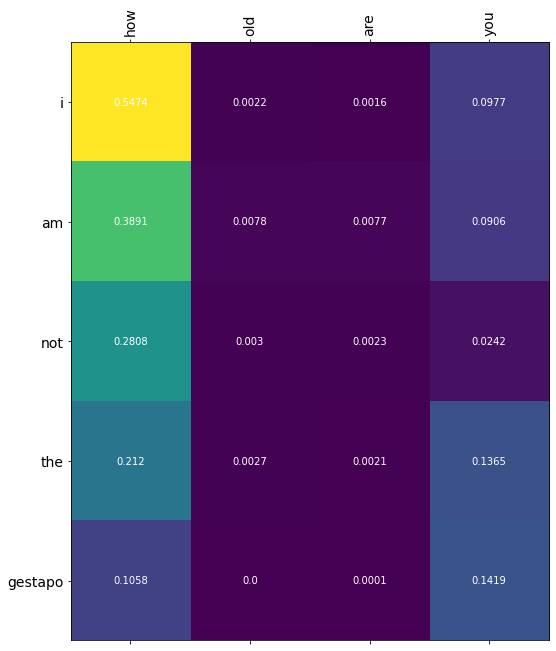

Input: where are you
Predicted answer: i am not 
Attention scores are:    [[0.60557461 0.00484357 0.12450156]
 [0.36417633 0.01016436 0.10283906]
 [0.28999004 0.00269546 0.02006894]]


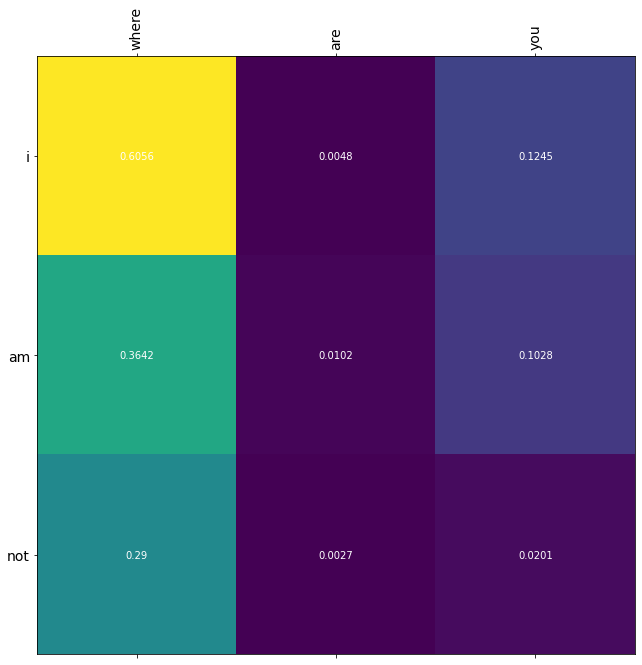

Input: do you drink
Predicted answer: no i am not 
Attention scores are:    [[0.5674352  0.00982716 0.10194959]
 [0.56464499 0.0105278  0.10346968]
 [0.39211631 0.00915136 0.09668017]
 [0.28103232 0.00264969 0.01944964]]


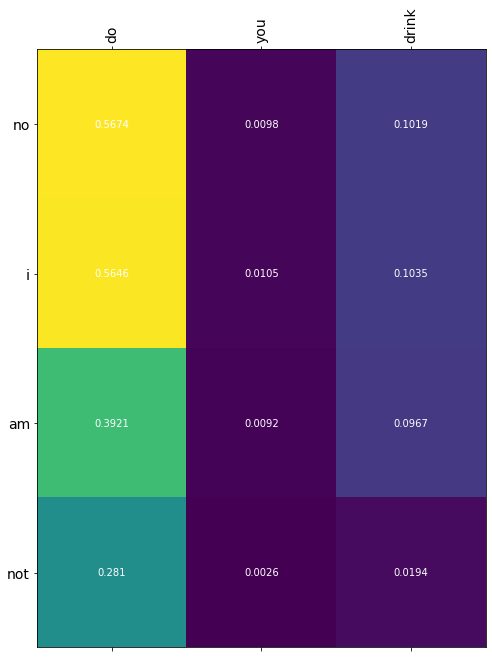

Input: do you have fever
Predicted answer: no 
Attention scores are:    [[0.56490207 0.00999617 0.00297187 0.10371563]]


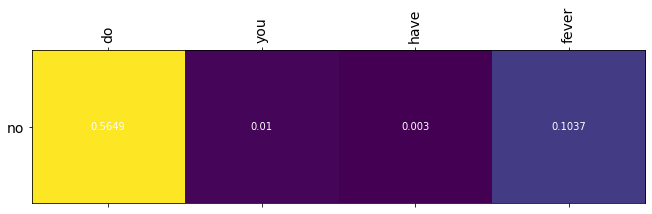

Input: what are you doing
Predicted answer: i am going to do 
Attention scores are:    [[0.54896462 0.00213553 0.00186512 0.12107737]
 [0.47971958 0.00603024 0.00467404 0.03719009]
 [0.3067663  0.00230708 0.00231872 0.01352751]
 [0.17794991 0.00282311 0.00304996 0.27587825]
 [0.06515408 0.00269162 0.00666648 0.20514441]]


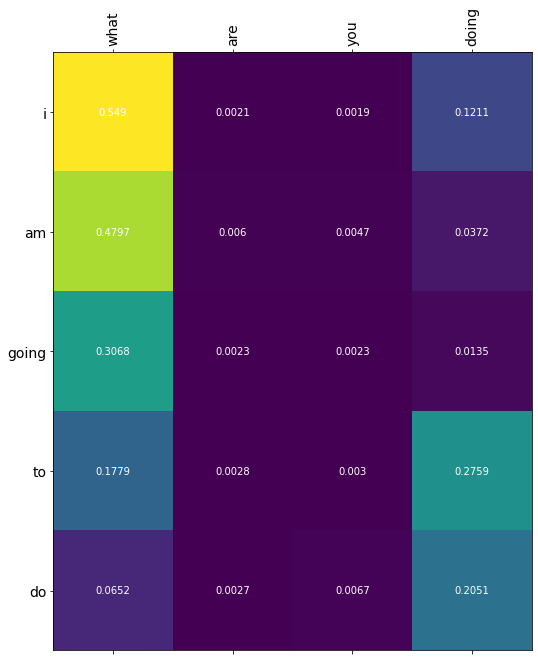

Input: do you like ice cream
Predicted answer: i am not 
Attention scores are:    [[0.56128287 0.01006159 0.00389507 0.00205482 0.10541929]
 [0.36978149 0.01003888 0.00687477 0.00441024 0.09272925]
 [0.28162026 0.00273392 0.00231674 0.00244733 0.01982568]]


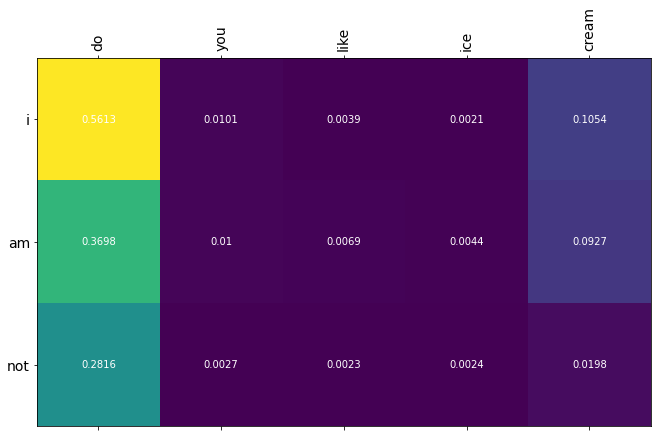

Input: do you smoke
Predicted answer: no i am not 
Attention scores are:    [[0.56869715 0.00516374 0.10507366]
 [0.54703593 0.00867985 0.12010782]
 [0.38112241 0.01005921 0.0908251 ]
 [0.2901338  0.0026353  0.01383788]]


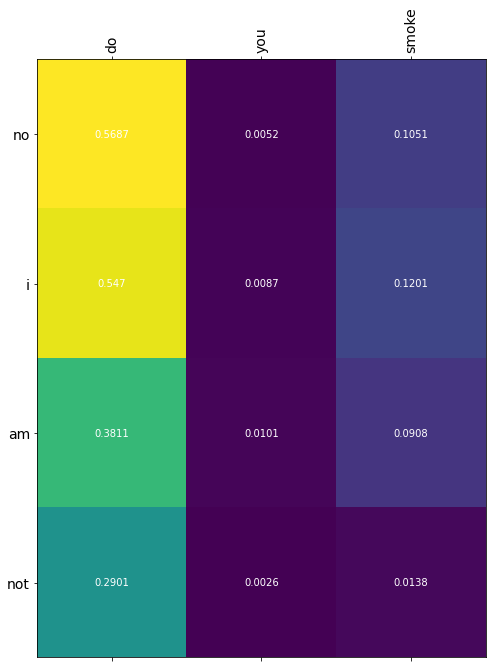

Input: what is your name
Predicted answer: i am sorry 
Attention scores are:    [[0.56178367 0.00219388 0.0015016  0.12170112]
 [0.50905508 0.00593862 0.00479201 0.05569693]
 [0.34724811 0.0035138  0.00227269 0.01299649]]


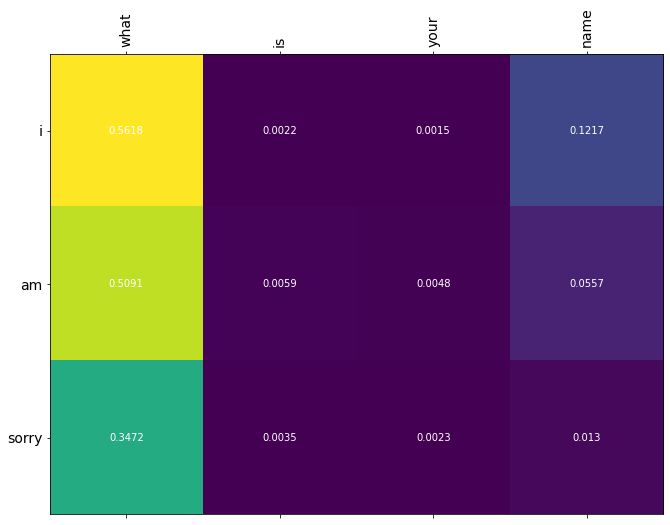

Input: what is your favourite sport
Predicted answer: i am sorry 
Attention scores are:    [[0.55458647 0.00359946 0.00341946 0.00386505 0.11423079]
 [0.44675586 0.00907334 0.00649268 0.00685134 0.02804917]
 [0.28383732 0.00221307 0.0020704  0.00204742 0.01822847]]


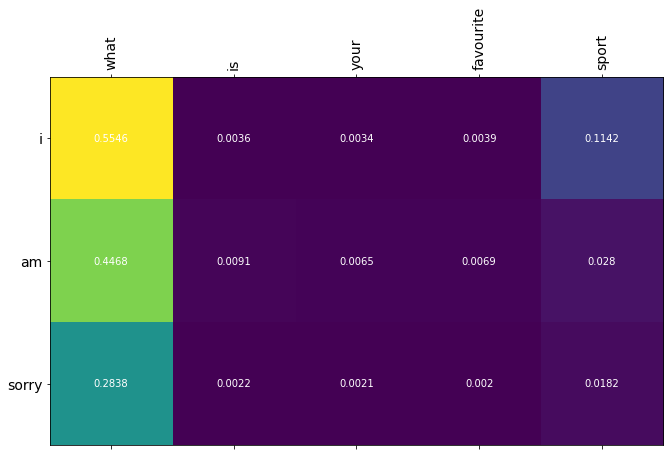

In [115]:
test_queries(49) # 50th epoch

### Testing our model number 140 (140th checkpoint) for 10 questions and printing its attention scores

Input: how are you
Predicted answer: i am not a long time ago 
Attention scores are:    [[5.61586440e-01 6.26472803e-03 1.09866649e-01]
 [4.17690516e-01 2.09582075e-02 2.70973779e-02]
 [3.28504145e-01 4.55656322e-03 1.26047805e-02]
 [2.80373722e-01 5.26705943e-03 4.97852378e-02]
 [8.75188261e-02 1.92436943e-04 2.61690654e-03]
 [3.95396709e-01 1.40576623e-03 1.30611435e-02]
 [3.89899939e-01 6.17686799e-03 1.22394592e-01]]


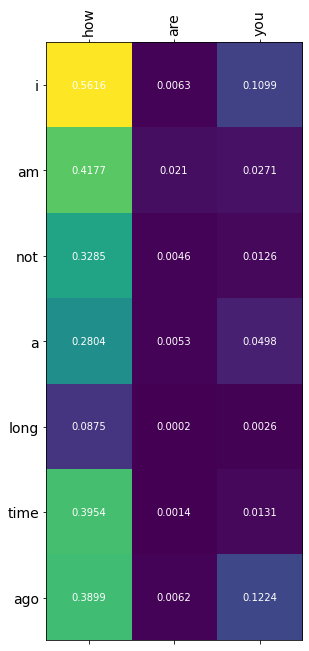

Input: how old are you
Predicted answer: sixteen 
Attention scores are:    [[0.61586046 0.00291663 0.00442512 0.01502317]]


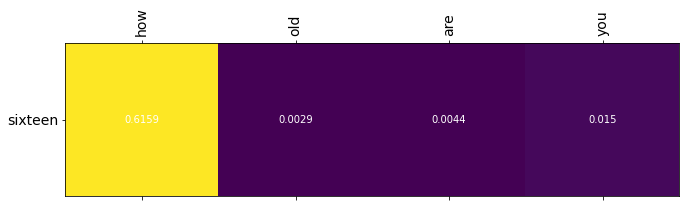

Input: where are you
Predicted answer: i am going to do it 
Attention scores are:    [[0.58753675 0.00460618 0.10673931]
 [0.40870821 0.02919935 0.07376268]
 [0.30305278 0.00631227 0.0108235 ]
 [0.2173319  0.0046475  0.25766206]
 [0.07037298 0.00939177 0.18938476]
 [0.0568909  0.0359855  0.36932886]]


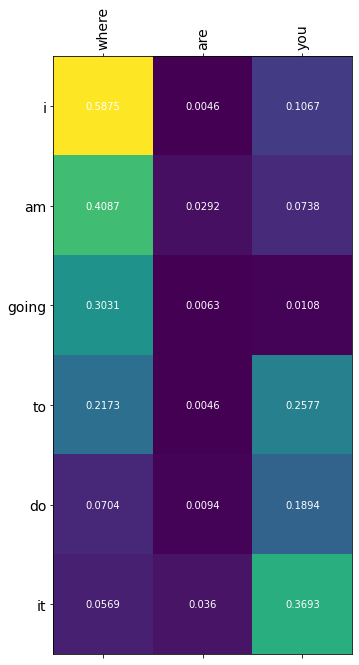

Input: do you drink
Predicted answer: no 
Attention scores are:    [[0.57178932 0.00708165 0.09898169]]


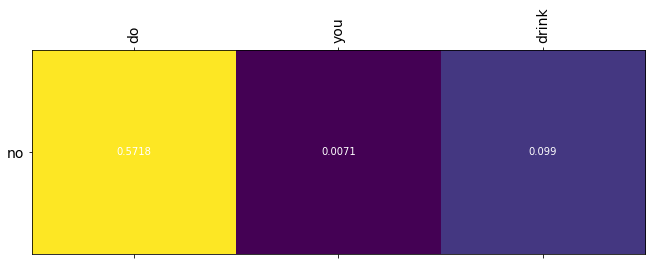

Input: do you have fever
Predicted answer: i am not sure 
Attention scores are:    [[0.55829042 0.00938506 0.00283044 0.10826277]
 [0.39358249 0.01349053 0.00318388 0.08191781]
 [0.27549192 0.00588758 0.00488395 0.01443809]
 [0.22455883 0.00676988 0.00333891 0.13644674]]


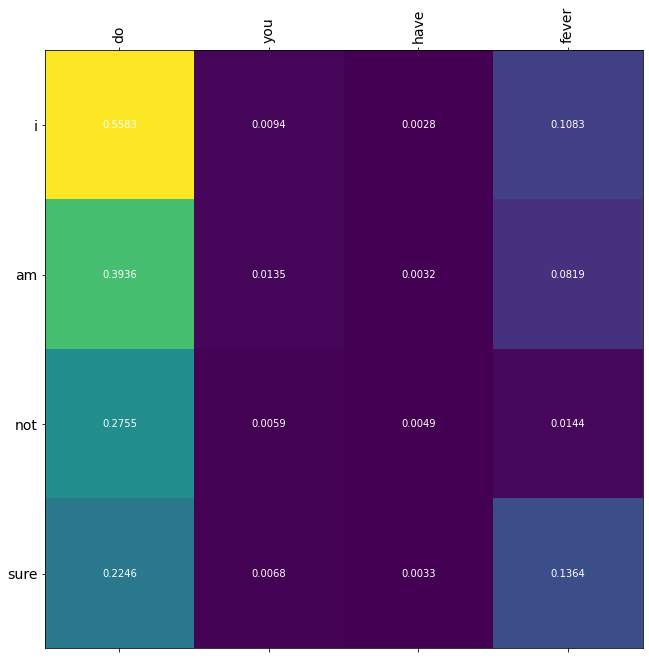

Input: what are you doing
Predicted answer: i am going to do it 
Attention scores are:    [[0.55475867 0.00298998 0.00131881 0.10827079]
 [0.45606431 0.0087427  0.00520968 0.02861689]
 [0.24587315 0.00392622 0.00427882 0.02246609]
 [0.20758709 0.00217416 0.00174369 0.26050517]
 [0.04384648 0.0038531  0.0089791  0.17137852]
 [0.03064968 0.04173778 0.02283354 0.41355449]]


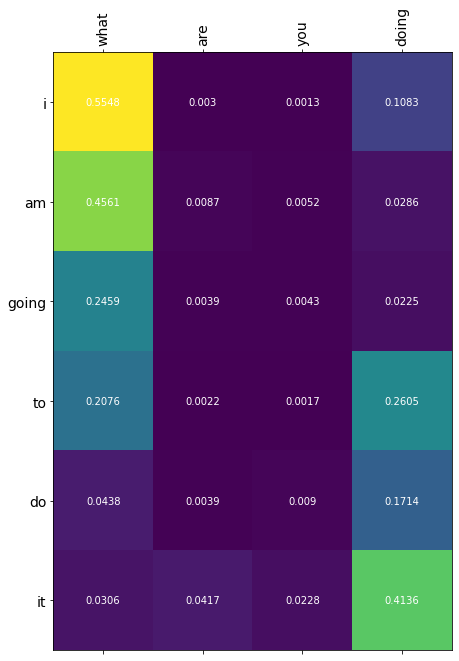

Input: do you like ice cream
Predicted answer: i am fine 
Attention scores are:    [[0.56172669 0.0109694  0.00295774 0.00240445 0.09853661]
 [0.41345462 0.01964055 0.00503562 0.00375577 0.04818455]
 [0.29562074 0.00598795 0.0049645  0.00455645 0.00990866]]


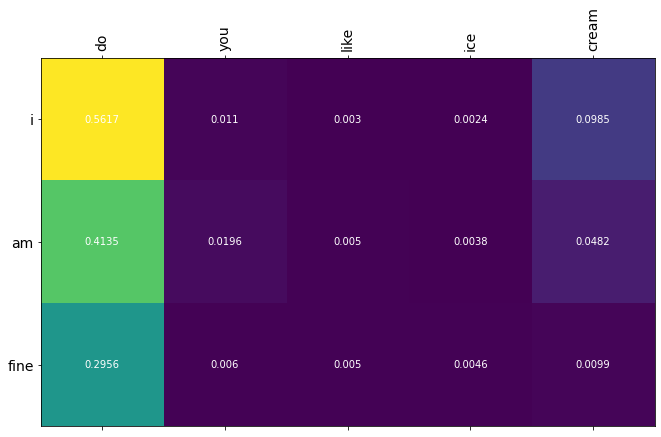

Input: do you smoke
Predicted answer: no 
Attention scores are:    [[0.568838   0.00387558 0.10039151]]


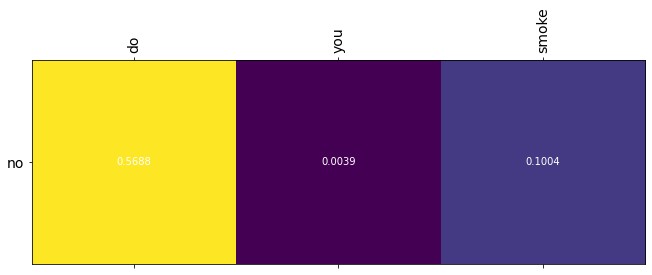

Input: what is your name
Predicted answer: i am gunning 
Attention scores are:    [[0.53840894 0.00409272 0.00522577 0.10888234]
 [0.46286747 0.00831423 0.00818388 0.02672266]
 [0.27415913 0.00427836 0.00327939 0.01077845]]


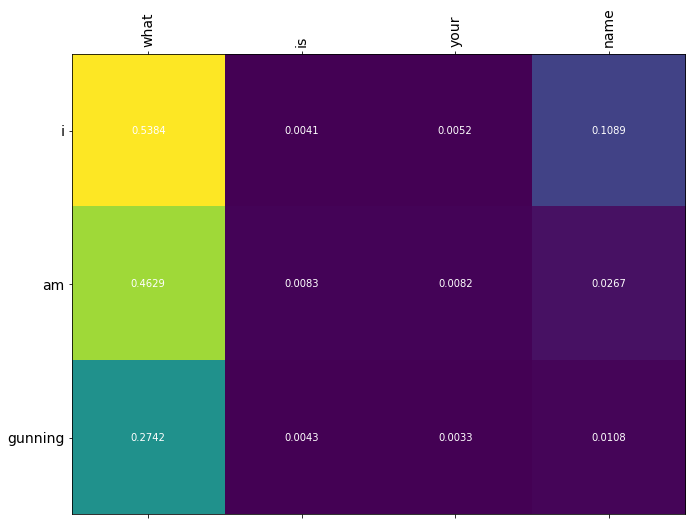

Input: what is your favourite sport
Predicted answer: i am sorry 
Attention scores are:    [[0.56001568 0.00995834 0.0087492  0.00943479 0.11593911]
 [0.44328508 0.01142659 0.00821853 0.01111628 0.02275659]
 [0.29112804 0.00446617 0.0041758  0.00417437 0.00907362]]


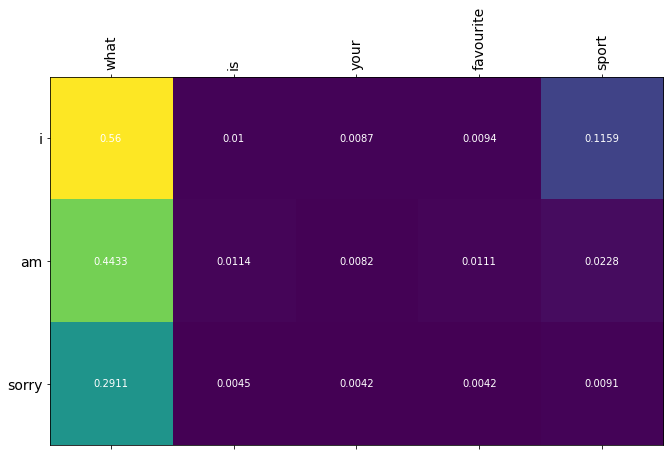

In [117]:
test_queries(139) 

# Answers: -

questions that are answered conatain code below to support the answers



 ### Question 1. Yes, it can be said that models learned to track local raltion between words. This can be validated from an example where a well trained model (for 140 epochs), responds to a question 'what is your favourite restaurant' by 'i am serving'. This does not mean that the model has given a perfect answer to the question, but the model was succesfully able to match the reklation between the words restaurants and serving. The other two models, ones trained on 5 and 50 epochs could not form this realtion. The answers for these 2 models seem irrelevant to the context of the question.

In [111]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")
test_bot()

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
####################


In [112]:
checkpoint.restore(str(emb_dim)+"-ckpt-50")
test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not going to be a little 
####################


In [113]:
checkpoint.restore(str(emb_dim)+"-ckpt-140")
test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not true 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am serving 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################


### Question 2

### The models tend to predict similar responses for every questions in the initial phase of training when the value of our model loss is high. Hence it can be said that the model was overfitiing in the initial epochs. For example:- Below are the output responses for the model 5. It can be seen that for all the questions the model has responded with ‘I am sorry’ which is a clear case of overfitting. But eventually, after more training and a decrease in the model loss, the model starts making good predictions and the overfitting reduces.

In [121]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")
test_bot()

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am sorry 
####################


### Question 3
### The model did make some major syntactic relations which can be validated with some examples. Our model better understands the question and produces better answers in later epochs. The below exmaple where the question is 'are you going to sleep'; As the training inceased the models produced better resulsts. The model 140 responded with a single word 'no' which means it answered the question perfectly. The model 50 also answered the question correctly by responding 'i am not'. Here 'you' is the subject and our model converted the subject to 'I' while responding.

Input: are you going to sleep
Predicted answer: i am sorry 
Attention scores are:    [[0.55457807 0.00560864 0.00424635 0.00432856 0.10463032]
 [0.42637905 0.00479754 0.00386634 0.00408422 0.0627427 ]
 [0.22811683 0.0020442  0.00156964 0.00146792 0.02236981]]


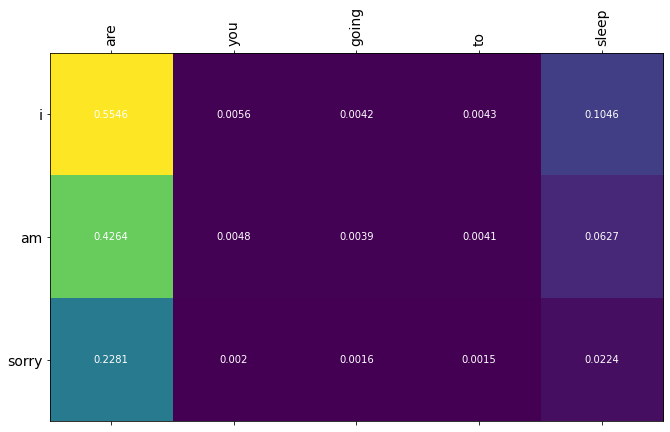

Input: are you going to sleep
Predicted answer: i am not 
Attention scores are:    [[0.55638629 0.01226328 0.00259869 0.00149874 0.10075233]
 [0.41217738 0.00992235 0.00516737 0.00381856 0.06182133]
 [0.29108453 0.00282375 0.00267963 0.00259579 0.01949196]]


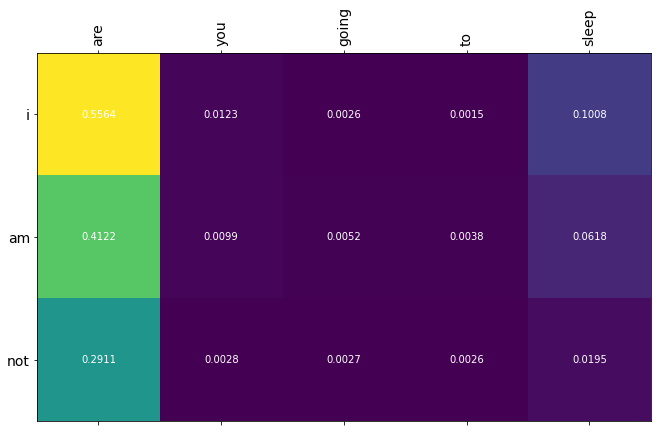

Input: are you going to sleep
Predicted answer: no 
Attention scores are:    [[0.56884265 0.00515287 0.00133374 0.00112727 0.0984316 ]]


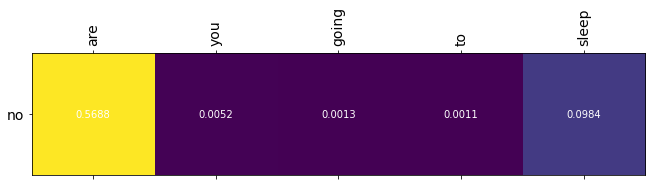

In [125]:
q1 = "are you going to sleep"
checkpoint.restore(str(emb_dim)+"-ckpt-5")
answer(q1, training=False)
checkpoint.restore(str(emb_dim)+"-ckpt-50")
answer(q1, training=False)
checkpoint.restore(str(emb_dim)+"-ckpt-140")
answer(q1, training=False)

### Question 4

### As we have not explicity added the POS tags or any other linguistic components as features to our model, we do not expect the model to capture such features. The model fails to identify proper nouns, or some tenses for example:- the model throws a key error if I ask a query 'when are you planning to meet me'. Changing 'planning' to 'plan' works, but the point is that the model is not trained to identify or learn POS tags.

Input: when do you plan to meet me
Predicted answer: i am not 
Attention scores are:    [[0.5343321  0.00496913 0.00336439 0.00202335 0.00262958 0.00255521
  0.12264032]
 [0.43534768 0.00606093 0.00326323 0.00242412 0.00251051 0.00244712
  0.05226302]
 [0.29240021 0.00598883 0.00379327 0.00344108 0.00443382 0.00401094
  0.01078472]]


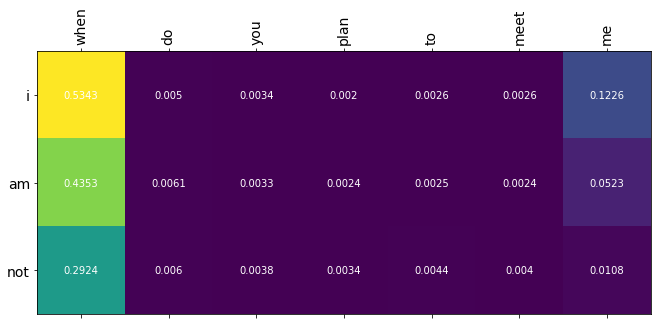

In [153]:
query = "when do you plan to meet me"
answer(query, training=False)

### Question 5. 

### Effect of more training on length of responses

### It can be observed from the above examples/experiments that more the training, shorter the predicted resposnes. This is becasue the models which are more trained tend to answer to the point and correctly instead of producing long false resposnes. Comparing the example of question "how old are you", model 50 returns a repeating "I am" sequence as the output whereas our model trained on 140 epochs just answers in a single word but correct. Again for the question "do you drink", the lesser trained model returns 'i am not' where as the model trained on 140 epochs retruns 'no' which is more appropriate to the question that was asked.

Input: how old are you
Predicted answer: i am sorry 
Attention scores are:    [[0.58115864 0.00323345 0.00367905 0.10093919]
 [0.45683575 0.00467216 0.00462146 0.0587715 ]
 [0.22525737 0.00140332 0.00151795 0.02157524]]


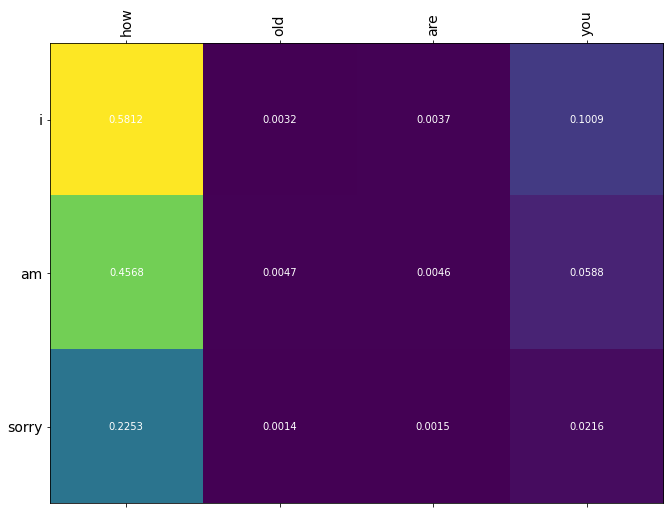

Input: do you drink
Predicted answer: i am sorry 
Attention scores are:    [[0.56266946 0.00731208 0.09655432]
 [0.43841729 0.00563397 0.05988441]
 [0.22215976 0.001779   0.01749141]]


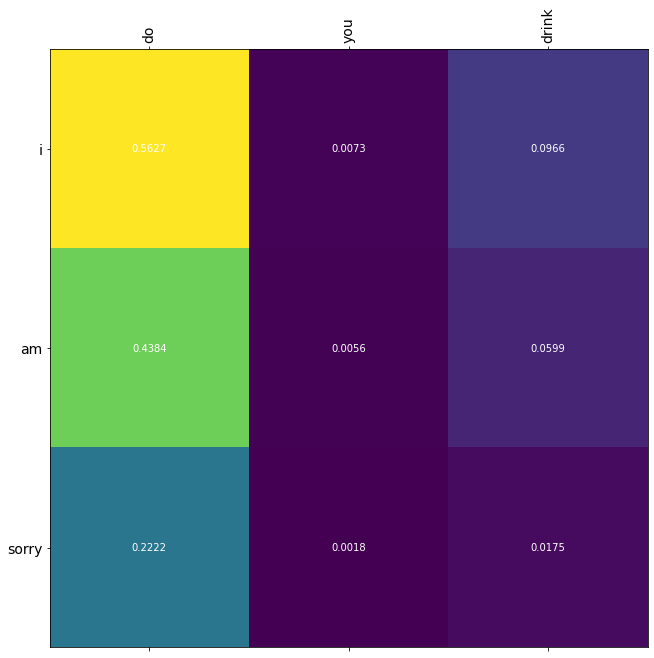

Input: how old are you
Predicted answer: i am i am i am i am i am i am i am i am i am 
Attention scores are:    [[0.51031542 0.00228203 0.00178046 0.09641837]
 [0.4517718  0.00688669 0.00595146 0.07801477]
 [0.3718161  0.00382409 0.00229524 0.01955774]
 [0.46315464 0.00538294 0.00402835 0.08344997]
 [0.37402633 0.00377356 0.00229662 0.01920341]
 [0.46445879 0.00537192 0.00399833 0.08297639]
 [0.37436953 0.00376321 0.00229305 0.01918302]
 [0.46465632 0.00537091 0.00399441 0.08290251]
 [0.37441865 0.00376165 0.00229249 0.01918015]
 [0.46468484 0.00537075 0.00399384 0.08289178]
 [0.37442514 0.00376141 0.00229241 0.01917968]
 [0.46468928 0.00537072 0.00399375 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]
 [0.46468928 0.00537072 0.00399374 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]
 [0.46468928 0.00537072 0.00399374 0.08289004]
 [0.37442687 0.00376137 0.00229239 0.01917962]]


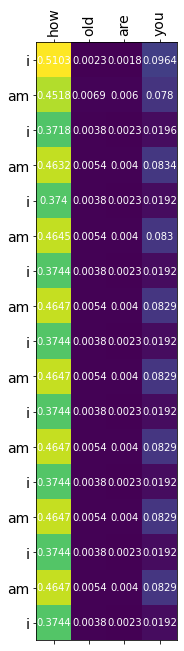

Input: do you drink
Predicted answer: i am not 
Attention scores are:    [[0.56624264 0.00991434 0.10310471]
 [0.38909161 0.0094708  0.0983879 ]
 [0.27326459 0.00243236 0.0242989 ]]


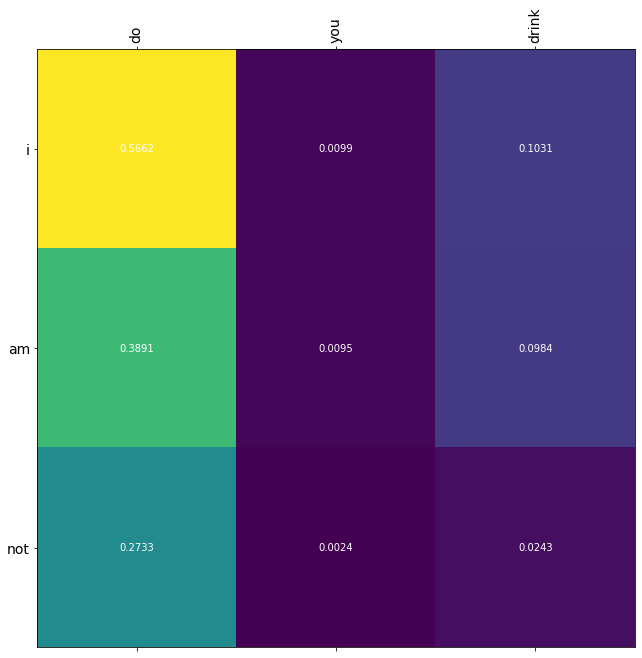

Input: how old are you
Predicted answer: sixteen 
Attention scores are:    [[0.52890342 0.00332699 0.00565497 0.02820913]]


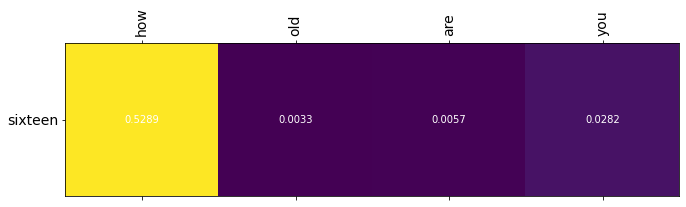

Input: do you drink
Predicted answer: no 
Attention scores are:    [[0.56450301 0.0092575  0.10305807]]


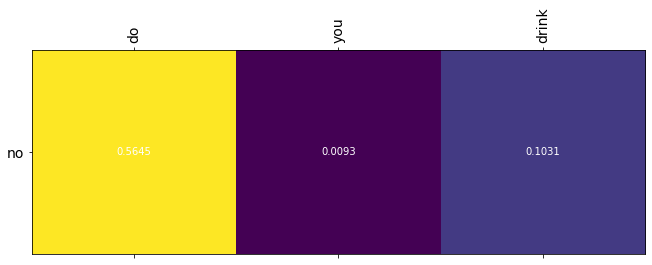

In [120]:
q1 = "How old are you"
q2 = "do you drink"
checkpoint.restore(str(emb_dim)+"-ckpt-5")
answer(q1, training=False)
answer(q2, training=False)
checkpoint.restore(str(emb_dim)+"-ckpt-50")
answer(q1, training=False)
answer(q2, training=False)
checkpoint.restore(str(emb_dim)+"-ckpt-140")
answer(q1, training=False)
answer(q2, training=False)

### Question 6 

### The main reason that the decoder forgetsthe beginning of a response is because LSTMs tend to retain the later values in a sequence for longer sequences, and hence pre-padding is a preffered technique where zeros are padded before the meaningful information so that the information with most significance is at the later parts of our sequence it retained when we use models like LSTM. In our case the model forgets the beginning of the response because we have performed post-padding instead of pre-padding. In post padding, the most significance information is stored in the later bits and the beginning of such sequences are zeros.